<a href="https://colab.research.google.com/github/tripuragorla/CMPE-297-Assignments/blob/main/Assignment%201/Supervised_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [1]:
!nvidia-smi

Wed Sep 22 21:26:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

     / 10.4 MB 784 kB/s
     |████████████████████████████████| 180 kB 5.4 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 139 kB 50.0 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 70 kB 8.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=15630c3b9415837ab10122e6ec984c83bb62f49036374b3e1545cde51643370e
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.whl size=7639 sha256=0e92e480557805e5337f56771b225d136faaf9ff71a4d4550fb3d6478e30dad2
  Stored in directory: /root/.cache/pip/wheels/b6/9a/56/5456fd32264a8fc53eefcb2f74e24e99a7ef4eb40a9af5c905
  Created wheel for graphql-core: filename=graphql_core-1.1-py3-none-any.whl size=104649 sha256=1a06f20616700c93376a1665e86dc

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [5]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 35.63 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [6]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [7]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [8]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

100%|██████████| 1250/1250 [00:06<00:00, 181.55it/s]


(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 188.56it/s]


(250, 224, 224, 3) (250,)


In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [10]:
# Set up TensorFlow dataset for performance optimization

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [11]:
# Architecture utils
def get_resnet():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    
    inputs = Input((224, 224, 3))
    features = base_model(inputs, training=False)
    pooled_features = GlobalAveragePooling2D()(features)

    pooled_features = Dense(256)(pooled_features)
    pooled_features = Activation("relu")(pooled_features)
    outputs = Dense(5, activation="softmax")(pooled_features)

    resnet_simclr = Model(inputs, outputs)

    return resnet_simclr

In [12]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [13]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [14]:
get_resnet().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 24,113,541
Trainable params: 24,060,421
Non-trainable params: 53,120
____________________________________________

wandb: Wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/50
20/20 [==============================] - 73s 2s/step - loss: 1.6840 - accuracy: 0.2136 - val_loss: 1.6095 - val_accuracy: 0.2000


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 1.6118 - accuracy: 0.2024 - val_loss: 1.6101 - val_accuracy: 0.2000
Epoch 3/50
20/20 [==============================] - 27s 1s/step - loss: 1.6109 - accuracy: 0.1952 - val_loss: 1.6082 - val_accuracy: 0.2000
Epoch 4/50
20/20 [==============================] - 28s 1s/step - loss: 1.5888 - accuracy: 0.2112 - val_loss: 1.6122 - val_accuracy: 0.2000
Epoch 5/50
20/20 [==============================] - 27s 1s/step - loss: 1.6110 - accuracy: 0.1952 - val_loss: 1.6087 - val_accuracy: 0.2080
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


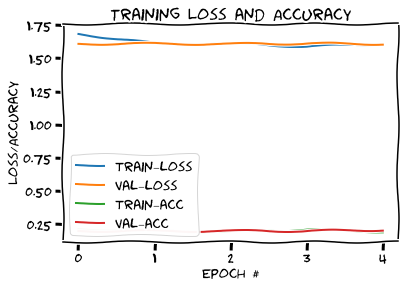

In [15]:
# Train the supervised model with full data
wandb.init(project="simclr", id="supervised-training")

model = get_resnet()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam(1e-3))
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[es, WandbCallback()])
plot_training(history)